In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [27]:
# Načtení dat
df = pd.read_csv('sorted_test_data.csv', parse_dates=['Date'])

In [28]:
df.head()

,Date,Equipment_ID,Priority,Duration
0,2023-01-01,3,2,7081
1,2023-01-02,1,1,4581
2,2023-01-03,2,3,3569
3,2023-01-04,1,2,1520
4,2023-01-05,1,1,3599


In [29]:
# Vybrání relevantních sloupců
data = df[['Duration', 'Priority', 'Equipment_ID']]

In [30]:
# Normalizace dat
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [31]:
scaled_data[:10]

array([[0.67589196, 0.5       , 1.        ],
       [0.39802156, 0.        , 0.        ],
       [0.28553962, 1.        , 0.5       ],
       [0.05779704, 0.5       , 0.        ],
       [0.28887407, 0.        , 0.        ],
       [0.62776481, 1.        , 0.5       ],
       [0.91686118, 1.        , 1.        ],
       [0.19751028, 0.5       , 0.        ],
       [0.27798155, 0.        , 0.        ],
       [0.22463043, 0.        , 1.        ]])

In [32]:
# Příprava trénovacích dat
X, y = [], []
for i in range(len(data)-60):
    X.append(scaled_data[i:i+60])
    y.append(scaled_data[i+60, 0])

X, y = np.array(X), np.array(y)

In [33]:
X.shape

(940, 60, 3)

In [34]:
from sklearn.model_selection import TimeSeriesSplit

In [35]:
# Vytvoření instance TimeSeriesSplit s počtem skládek (folds) dle počtu epoch
tscv = TimeSeriesSplit(n_splits=10)

In [36]:
# Inicializace prázdných seznamů pro trénovací a testovací data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

In [37]:
# Rozdělení dat pomocí časově řazené křížové validace
for train_index, test_index in tscv.split(X):
    X_train_list.append(X[train_index])
    X_test_list.append(X[test_index])
    y_train_list.append(y[train_index])
    y_test_list.append(y[test_index])

In [38]:
# Definice LSTM modelu
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           41600     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71851 (280.67 KB)
Trainable params: 71851 (280.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# Připravení seznamu pro ukládání hodnot loss
train_loss_history = []
val_loss_history = []

In [41]:
# Trénování modelu na jedné epochě v každém kroku křížové validace
for i in range(len(X_train_list)):
    X_train_fold, y_train_fold = X_train_list[i], y_train_list[i]
    X_test_fold, y_test_fold = X_test_list[i], y_test_list[i]

    # Trénování modelu na jedné epochě
    history = model.fit(X_train_fold, y_train_fold, epochs=1, batch_size=32, validation_data=(X_test_fold, y_test_fold))

    # Uložení hodnot loss do seznamů
    train_loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

27/27 [==============================] - 2s 61ms/step - loss: 0.0828 - val_loss: 0.0762


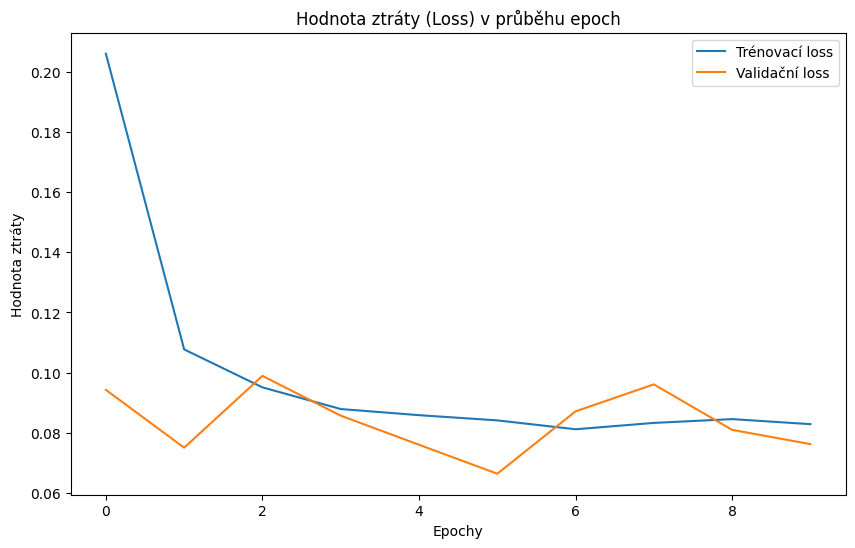

In [42]:
# Vykreslení loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Trénovací loss')
plt.plot(val_loss_history, label='Validační loss')
plt.title('Hodnota ztráty (Loss) v průběhu epoch')
plt.xlabel('Epochy')
plt.ylabel('Hodnota ztráty')
plt.legend()
plt.show()

3/3 [==============================] - 0s 24ms/step


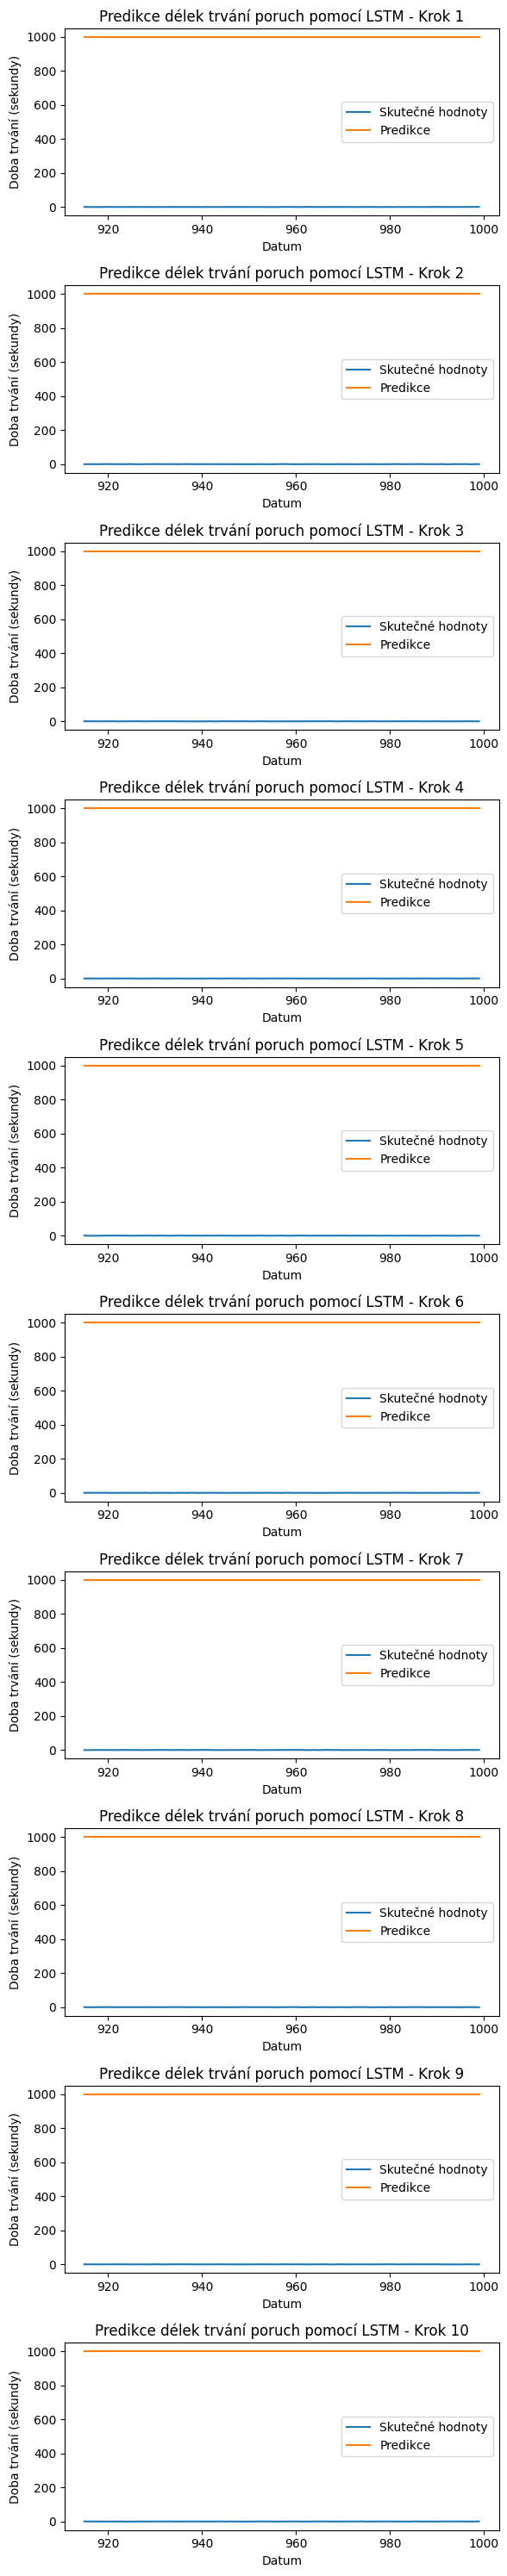

In [43]:
# Inicializace velkého plátna pro všechny grafy
plt.figure(figsize=(6, 3 * len(X_test_list)))

# Predikce a vizualizace pro každý krok křížové validace
for i in range(len(X_test_list)):
    X_test_fold, y_test_fold = X_test_list[i], y_test_list[i]

    # Predikce na testovacích datech
    predictions = model.predict(X_test_fold)
    predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), 2)), predictions), axis=1))[:, 0]

    # Přidání subgrafu na velké plátno
    plt.subplot(len(X_test_list), 1, i+1)
    plt.plot(df.index[-len(y_test_fold):], y_test_fold, label='Skutečné hodnoty')
    plt.plot(df.index[-len(predictions):], predictions, label='Predikce')
    plt.title(f'Predikce délek trvání poruch pomocí LSTM - Krok {i+1}')
    plt.xlabel('Datum')
    plt.ylabel('Doba trvání (sekundy)')
    plt.legend()

# Nastavení vzdálenosti mezi subgrafy
plt.tight_layout()

# Zobrazení jediného obrázku
plt.show()